# 🎯 Confidence Score Calibration Demo

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
     Confidence scores from uncertainty quantification methods may not be well-calibrated probabilities. This demo demonstrates how to transform raw confidence scores into calibrated probabilities that better reflect the true likelihood of correctness using the <code>ScoreCalibrator</code> class.
  </p>
</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold">Generate simulated confidence scores and correctness labels</p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Create realistic example data that mimics UQ results with varying calibration quality.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold">Compare calibration methods</p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Evaluate uncalibrated scores vs Platt scaling vs Isotonic regression.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold">Visualize calibration quality</p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate reliability diagrams and compute calibration metrics like ECE and Brier score.</p>
  </div>
</div>

## ⚖️ Calibration Methods

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 100, 200, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 100, 200, 0.2)">
    <h3 style="color: #1e40af; margin-top: 0">Platt Scaling</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Method:</strong> Logistic regression</li>
      <li><strong>Parametric:</strong> Assumes sigmoid-shaped calibration function</li>
      <li><strong>Best for:</strong> Small datasets, well-behaved score distributions</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Isotonic Regression</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Method:</strong> Non-parametric, monotonic</li>
      <li><strong>Flexible:</strong> Can handle any monotonic calibration curve</li>
      <li><strong>Best for:</strong> Larger datasets, complex score distributions</li>
    </ul>
  </div>
</div>

In [1]:
from uqlm import WhiteBoxUQ
from uqlm.utils.score_calibrator import ScoreCalibrator
from uqlm.utils import load_example_dataset, math_postprocessor

## 1. Set up LLM and Prompts

For this demo, we'll use 250 prompts from GSM-8K benchmark, first 200 samples will be used to train the calibrators and rest of the 50 prompts will be used as test dataset.

In [2]:
n_prompts, n_test = 1000, 200

# Load example dataset for prompts/answers (optional, for context)
gsm8k = load_example_dataset("gsm8k", n=n_prompts)
print(f"Loaded {len(gsm8k)} questions from GSM8K dataset")

# Define prompts
MATH_INSTRUCTION = "When you solve this math problem only return the answer with no additional text.\n"
prompts = [MATH_INSTRUCTION + prompt for prompt in gsm8k.question][: (n_prompts - n_test)]

Loading dataset - gsm8k...
Processing dataset...
Dataset ready!
Loaded 1000 questions from GSM8K dataset


In this example, we use `AzureChatOpenAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [3]:
# import sys
# !{sys.executable} -m pip install langchain-openai

# # User to populate .env file with API credentials
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
llm = AzureChatOpenAI(
    deployment_name="gpt-4o",
    openai_api_type="azure",
    openai_api_version="2024-02-15-preview",
    temperature=1,  # User to set temperature
)

<a id='section2'></a>
## 2. Compute Confidence Scores
We generate model responses and associated confidence scores by leveraging the `WhiteBoxUQ` class. This class generates responses (used GPT-4o in this notebook) to prompts, while also estimating a confidence score for each response usign token probabilities.

In [4]:
wbuq = WhiteBoxUQ(llm=llm, max_calls_per_min=200)
results = await wbuq.generate_and_score(prompts=prompts)

# Convert to dataframe and grade responses against correct answers
result_df = results.to_df()
result_df["response_correct"] = [math_postprocessor(r) == a for r, a in zip(result_df["response"], gsm8k["answer"].tolist()[: (n_prompts - n_test)])]
result_df.head()

Output()

,prompt,response,logprob,normalized_probability,min_probability,response_correct
0,When you solve this math problem only return t...,72,"[{'token': '72', 'bytes': [55, 50], 'logprob':...",0.998665,0.998665,True
1,When you solve this math problem only return t...,$10,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.997821,0.995648,True
2,When you solve this math problem only return t...,$20,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.951882,0.936027,False
3,When you solve this math problem only return t...,48,"[{'token': '48', 'bytes': [52, 56], 'logprob':...",0.997090,0.997090,False
4,When you solve this math problem only return t...,624,"[{'token': '624', 'bytes': [54, 50, 52], 'logp...",0.999936,0.999936,True


<a id='section3'></a>
## 3. Score Calibration
Confidence scores from uncertainty quantification methods may not be well-calibrated probabilities. You can transform raw confidence scores into calibrated probabilities that better reflect the true likelihood of correctness using the calibrate_scores method.

The first step is to train the claibrators that can done using `fit` or `fit_transform` method of `ScoreCalibrator` class. You can initiate a class object by choosing a method for training calibrators. Then call `fit_transform` method be providing `UQResult` object from training dataset and correct responses.

In [5]:
sc_object = ScoreCalibrator(method="isotonic")
sc_object.fit_transform(results, result_df.response_correct)

results_df = results.to_df()
results_df.head()

,prompt,response,logprob,normalized_probability,min_probability,calibrated_normalized_probability,calibrated_min_probability
0,When you solve this math problem only return t...,72,"[{'token': '72', 'bytes': [55, 50], 'logprob':...",0.998665,0.998665,0.925000,0.920000
1,When you solve this math problem only return t...,$10,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.997821,0.995648,0.925000,0.888889
2,When you solve this math problem only return t...,$20,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.951882,0.936027,0.750000,0.771084
3,When you solve this math problem only return t...,48,"[{'token': '48', 'bytes': [52, 56], 'logprob':...",0.997090,0.997090,0.868421,0.888889
4,When you solve this math problem only return t...,624,"[{'token': '624', 'bytes': [54, 50, 52], 'logp...",0.999936,0.999936,1.000000,1.000000


You can evaluate the performance of calibrated scores using `evaluate_calibration` method, which will require the correct responses.

In [6]:
# Uncomment the following lines to visualize the calibrated scores

# metrics = sc_object.evaluate_calibration(results, result_df.response_correct)
# metrics

Lets generate responses and compute score on test dataset using `wbuq` object, which will return a `UQResult` object on test dataset which will contain test prompts, responses, and confidence scores.

In [7]:
test_prompts = [MATH_INSTRUCTION + prompt for prompt in gsm8k.question][-n_test:]

test_result = await wbuq.generate_and_score(test_prompts)

Output()

`sc_object` is ScoreCalibrator object that have fitted calibrators for each scorer. Now, we can call `transform` method and provide a test dataset (UQResult object form test prompts), which will update the `UQResult` object to include calibrated scores.

Note: `transform` method updates `UQResult` object, such that for every 'score', it will also contain 'calibrated_score'.

In [8]:
# Calibrate scores
sc_object.transform(test_result)

test_result_df = test_result.to_df()
test_result_df.head()

,prompt,response,logprob,normalized_probability,min_probability,calibrated_normalized_probability,calibrated_min_probability
0,When you solve this math problem only return t...,$4,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.594018,0.356061,0.307692,0.275000
1,When you solve this math problem only return t...,$345,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.562572,0.317951,0.288136,0.275000
2,When you solve this math problem only return t...,21,"[{'token': '21', 'bytes': [50, 49], 'logprob':...",0.739747,0.739747,0.459459,0.558824
3,When you solve this math problem only return t...,$17,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.450740,0.213615,0.253165,0.184783
4,When you solve this math problem only return t...,2,"[{'token': '2', 'bytes': [50], 'logprob': -9.3...",0.999906,0.999906,1.000000,1.000000


Lets evaluate calibrated score from test dataset (since we also have correct response on test dataset)

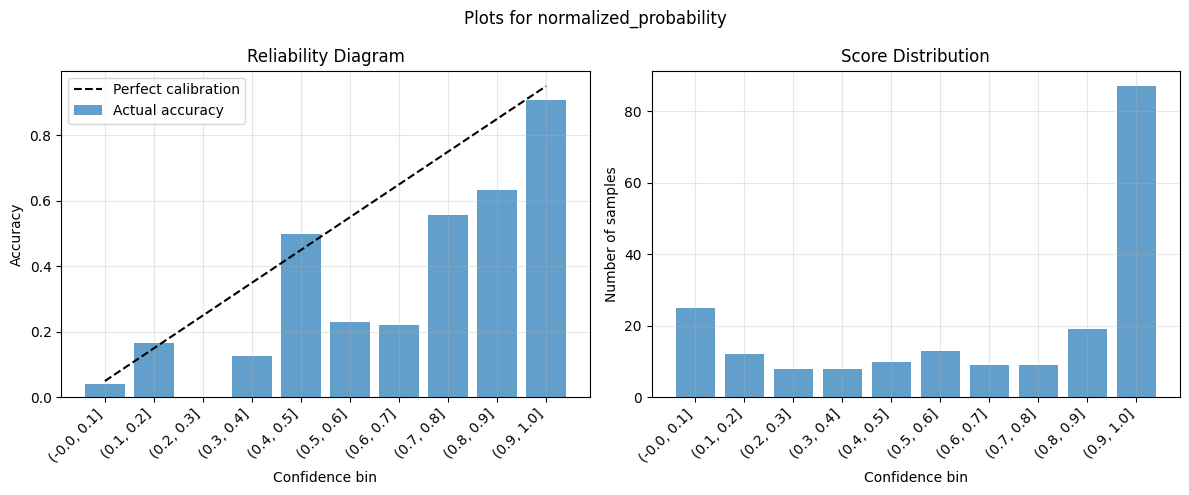

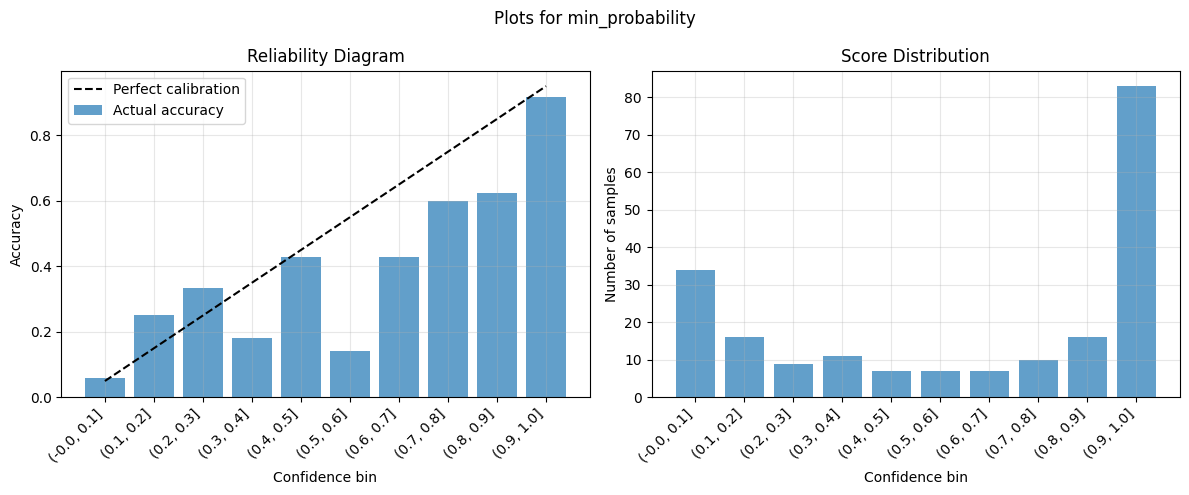

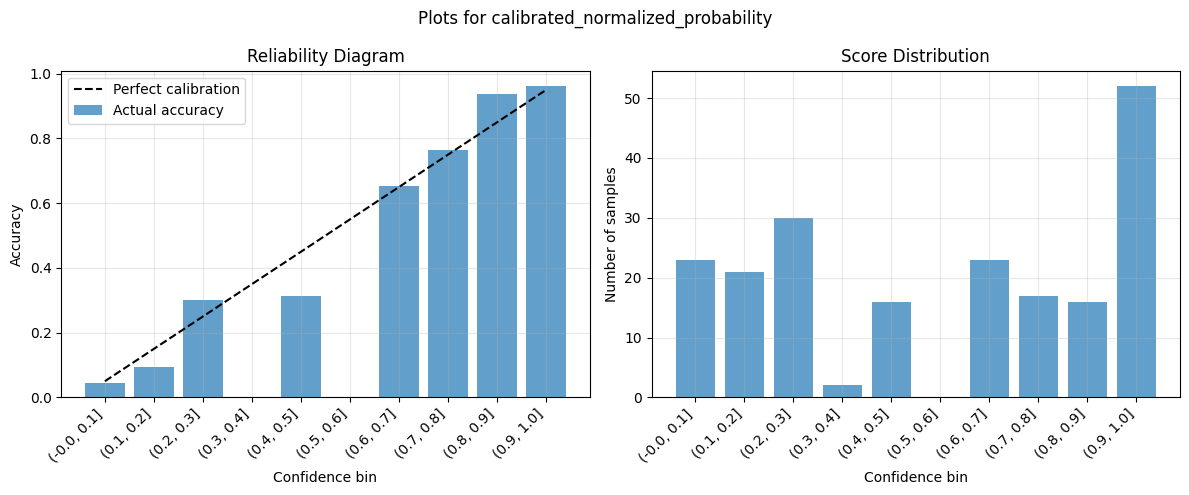

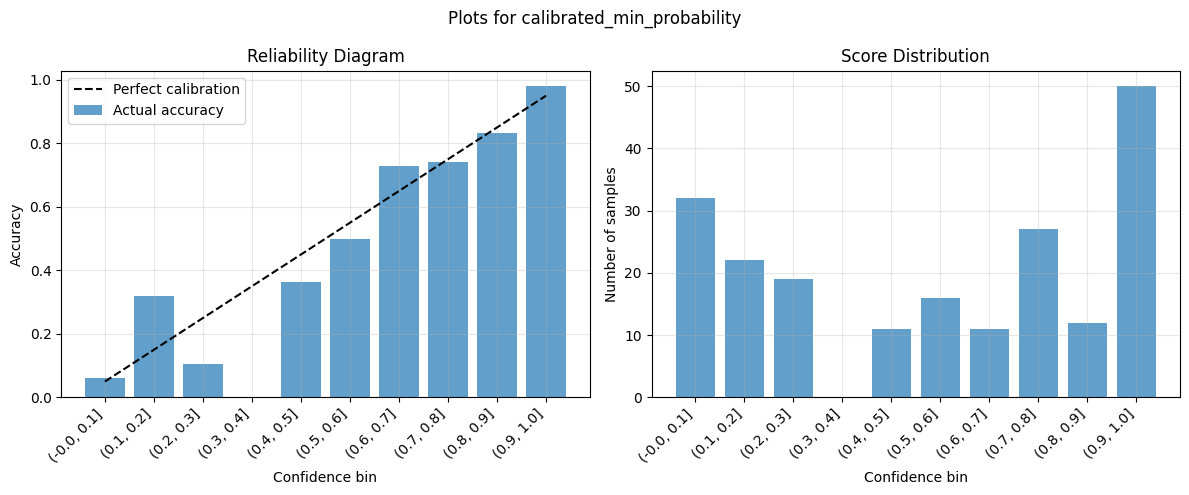

,average_confidence,average_accuracy,calibration_gap,brier_score,log_loss,ece,mce
normalized_probability,0.668035,0.55,0.118035,0.144298,0.634276,0.128091,0.435805
min_probability,0.619799,0.55,0.069799,0.142385,0.631714,0.103750,0.404203
calibrated_normalized_probability,0.555309,0.55,0.005309,0.120563,0.537850,0.037294,0.307692
calibrated_min_probability,0.564632,0.55,0.014632,0.130475,0.561560,0.051829,0.164149


In [9]:
# Grade responses against correct answers
test_result_df["response_correct"] = [math_postprocessor(r) == a for r, a in zip(test_result_df["response"], gsm8k["answer"].tolist()[-n_test:])]

test_metrics = sc_object.evaluate_calibration(test_result, test_result_df.response_correct)
test_metrics

## 4. Summary

This calibration analysis demonstrates:

### 🎯 **Key Findings**

1. **Calibration Quality**: Use reliability diagrams and metrics like ECE and MCE score to assess how well confidence scores reflect true probabilities

2. **Method Selection**: 
   - **Platt Scaling** works well for smaller datasets and when the calibration curve is roughly sigmoid-shaped
   - **Isotonic Regression** is more flexible and can handle complex, non-parametric calibration curves

3. **Practical Impact**: Calibration can significantly improve:
   - Reliability of confidence scores for decision-making
   - User trust in model predictions

---

© 2025 CVS Health and/or one of its affiliates. All rights reserved.